<a href="https://colab.research.google.com/github/xwang222/My-Projects/blob/main/Time_Series%20-%20ARIMA%20Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Packages and Define Necessary Functions

In [1]:
#@title Loading Packages
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import statsmodels.api as smi
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from tqdm import tqdm
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
import statsmodels.tsa.arima.model
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import norm
import numpy as np
from sklearn.metrics import r2_score

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")

# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

2.8.2


In [2]:
#@title Define Evaluation Tests
# Define Tests
# KPSS test
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

# MZ test
def MZ(FE):
  df=pd.DataFrame(FE)
  df['C']=yhat
  Y=df['pollution_today']
  X=df['C']
  X = smi.add_constant(X)
  OLS = smi.OLS(Y,X)
  results = OLS.fit()
  MZ = 0
  if results.pvalues[1]> 0.1:
    MZ =1
  
  return MZ

# MPE test
def MPE(FE):
  df=pd.DataFrame(FE)
  df['C']=1
  Y=df['pollution_today']
  X=df['C']
  OLS = smi.OLS(Y,X)
  results = OLS.fit()
  MPE = 0
  if results.pvalues[0]> 0.1:
    MPE =1
  
  return MPE

# plot diagnostics
def diag(e,name):
  e_mean = e.mean()
  e_std = e.std()
  e_p = e.apply(lambda x: (x - e_mean) / e_std)
  x_axis = np.arange(-5, 5, 0.1)

  fig, ax = plt.subplots(2,2,figsize=(13,8))
  ax[0, 0].plot(e_p)
  smi.graphics.tsa.plot_acf(e, lags=20, ax=ax[1,0])
  smi.qqplot(e,line="r", ax=ax[1,1])
  sns.distplot(e_p, hist=True, kde=True, 
              bins=int(180/5), color = 'blue', 
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth': 4}, ax=ax[0,1])
  ax[0, 1].plot(x_axis,norm.pdf(x_axis,0, 1),color="r")

  ax[0, 0].title.set_text('Standardized Residual over Time')
  ax[0, 1].title.set_text('Histogram + Density of Standardized Residual')
  ax[1, 0].title.set_text('Correlogram')
  ax[1, 1].title.set_text('QQ Plot')

  plt.show()
  plt.savefig(name)

# LBQ test
def lbq_test(res, alphaLBQ = 0.05, lags = 10,  plot = 0):
    lbq = acorr_ljungbox(res, lags=lags)
    out_pass = 0
    print('\033[1mLjung-Box Test\033[0m (H0: the samples are uncorrelated)\n')
    for i in lbq[1]:
      if i < alphaLBQ:
        print('Hypothesis H0 rejected → the samples are correlated\n')
        out_pass = 0 
        break
    else:
      print('Hypothesis H0 not rejected → the samples are uncorrelated\n')
      out_pass = 1

    if plot == 1:
      plt.rcParams["figure.figsize"] = 8, 4
      sns.set_style("white")
      acf_lbq = plot_acf(res, lags=lags, alpha=alphaLBQ)

    return out_pass

In [3]:
#@title Define Helper Fucntions for Evaluation
# Evaluation Metrics
EPSILON = 1e-10

def _error(actual: np.ndarray, predicted: np.ndarray):
    """Simple error"""
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """Naive forecasting method which just repeats previous samples"""
    return actual[:-seasonality]


def _relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) / (
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
            + EPSILON
        )

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Bounded Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
        )
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """Geometric mean"""
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """Mean Squared Error"""
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """Root Mean Squared Error"""
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Root Mean Squared Error"""
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """Mean Error"""
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """Mean Absolute Error"""
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """Geometric Mean Absolute Error"""
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """Median Absolute Error"""
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """Mean Percentage Error"""
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Error"""
    __mae = mae(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted) - __mae)) / (len(actual) - 1)
    )


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Percentage Error"""
    __mape = mape(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_percentage_error(actual, predicted) - __mape))
        / (len(actual) - 1)
    )


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """Root Mean Squared Scaled Error"""
    q = np.abs(_error(actual, predicted)) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """Integral Normalized Root Squared Error"""
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted)))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """Root Relative Squared Error"""
    return np.sqrt(
        np.sum(np.square(actual - predicted))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Error"""
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """Relative Absolute Error (aka Approximation Error)"""
    return np.sum(np.abs(actual - predicted)) / (
        np.sum(np.abs(actual - np.mean(actual))) + EPSILON
    )


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Absolute Error"""
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Median Relative Absolute Error"""
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Geometric Mean Relative Absolute Error"""
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Bounded Relative Absolute Error"""
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Unscaled Mean Bounded Relative Absolute Error"""
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """Mean Directional Accuracy"""
    return np.mean(
        (
            np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])
        ).astype(int)
    )


def bias(actual: np.ndarray, predicted: np.ndarray):
    """Mean forecast error(or Forecast Bias)"""
    return np.mean(actual - predicted)


METRICS = {
    "mse": mse,
    "rmse": rmse,
    "nrmse": nrmse,
    "me": me,
    "mae": mae,
    "mad": mad,
    "gmae": gmae,
    "mdae": mdae,
    "mpe": mpe,
    "mape": mape,
    "mdape": mdape,
    "smape": smape,
    "smdape": smdape,
    "maape": maape,
    "mase": mase,
    "std_ae": std_ae,
    "std_ape": std_ape,
    "rmspe": rmspe,
    "rmdspe": rmdspe,
    "rmsse": rmsse,
    "inrse": inrse,
    "rrse": rrse,
    "mre": mre,
    "rae": rae,
    "mrae": mrae,
    "mdrae": mdrae,
    "gmrae": gmrae,
    "mbrae": mbrae,
    "umbrae": umbrae,
    "mda": mda,
    "bias": bias,
    "r2": r2_score,
}


def evaluate(
    actual: np.ndarray, predicted: np.ndarray, metrics=("mae", "rmse", "mape", "r2")
):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

### Loading Data

In [4]:
air_pollution = pd.read_csv('/content/drive/MyDrive/air_pollution.csv', parse_dates=['date'])
air_pollution.set_index('date', inplace=True)
air_pollution.head()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333


### 1. Stationarity Check

#### 1.1 Graph check
The plot below didn't show a clear trend and the variance seems to be stable over time.

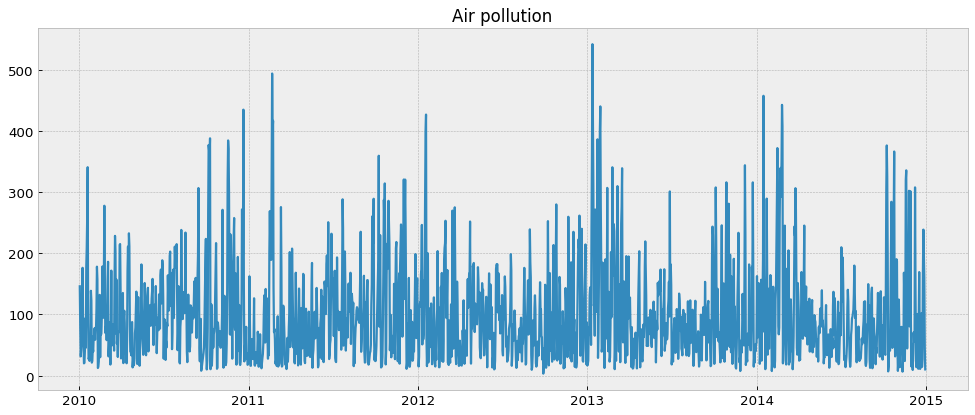

In [5]:
# 1.1 Graph check
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Air pollution', fontsize=15)

plt.plot(air_pollution.pollution_today)

#### 1.2 Formal Tests
Both tests show that the process is stationary. Therefore, we can proceed to the next step. Otherwise, we need to transform the data before we proceed.

In [6]:
# 1.2 Formal Tests
# ADF test
X = air_pollution.pollution_today.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# KPSS test
kpss_test(air_pollution.pollution_today.values)

# Transform the data if necessary

ADF Statistic: -10.116719
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Results of KPSS Test:
Test Statistic            0.061675
p-value                   0.100000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


### 2. ARIMA Model Proposal and Diagnostics

#### 2.1 ACF and PACF

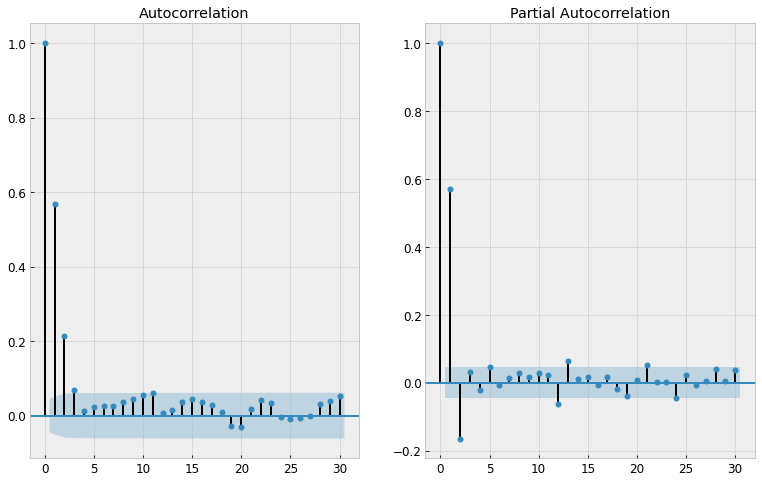

In [7]:
# 2.1 ACF and PACF
series = air_pollution.pollution_today.values
fig, ax = plt.subplots(1,2,figsize=(13,8))
plot_acf(series, lags=30, ax=ax[0])
plot_pacf(series, lags=30, ax=ax[1])
plt.show()

In [8]:
# Split train and test
resultsDict = {}
predictionsDict = {}

split_date = '2014-01-01'
df_training = air_pollution.loc[air_pollution.index <= split_date]
df_test = air_pollution.loc[air_pollution.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

#df_training.to_csv('datasets/training.csv')
#df_test.to_csv('datasets/test.csv')

1461 days of training data 
 364 days of testing data 


#### 2.2 Build Candidate Models and perform diagnostics

100%|██████████| 364/364 [01:29<00:00,  4.09it/s]


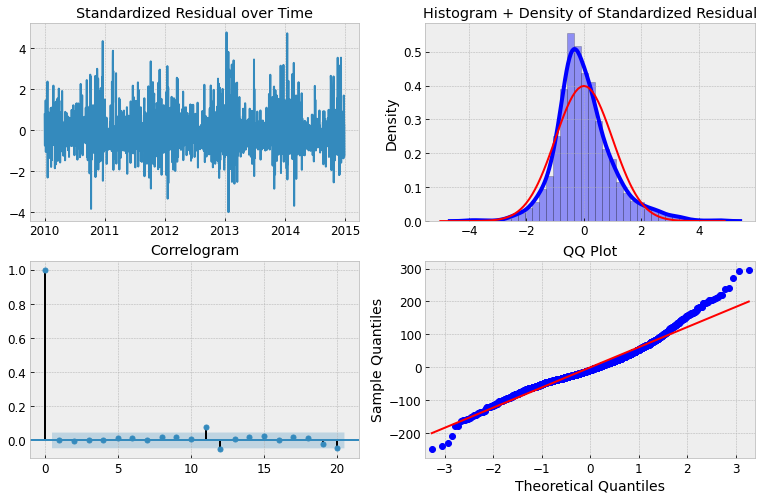

Ljung-Box Test (H0: the samples are uncorrelated)

Hypothesis H0 not rejected → the samples are uncorrelated



100%|██████████| 364/364 [00:32<00:00, 11.04it/s]


<Figure size 432x288 with 0 Axes>

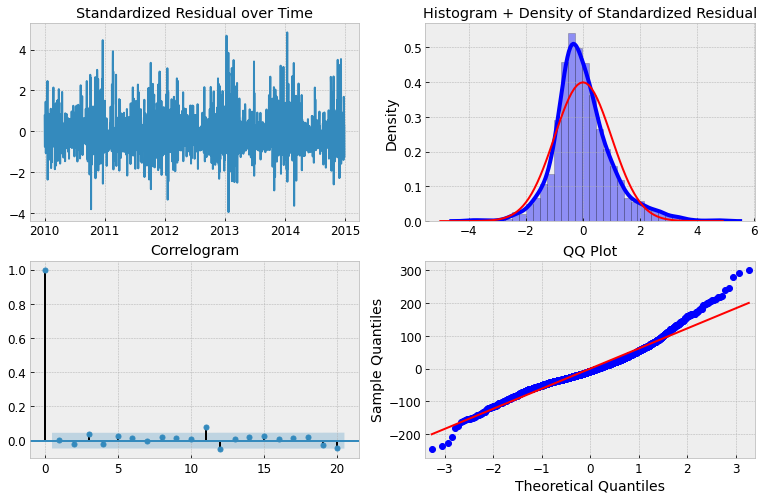

Ljung-Box Test (H0: the samples are uncorrelated)

Hypothesis H0 not rejected → the samples are uncorrelated



100%|██████████| 364/364 [01:33<00:00,  3.91it/s]


<Figure size 432x288 with 0 Axes>

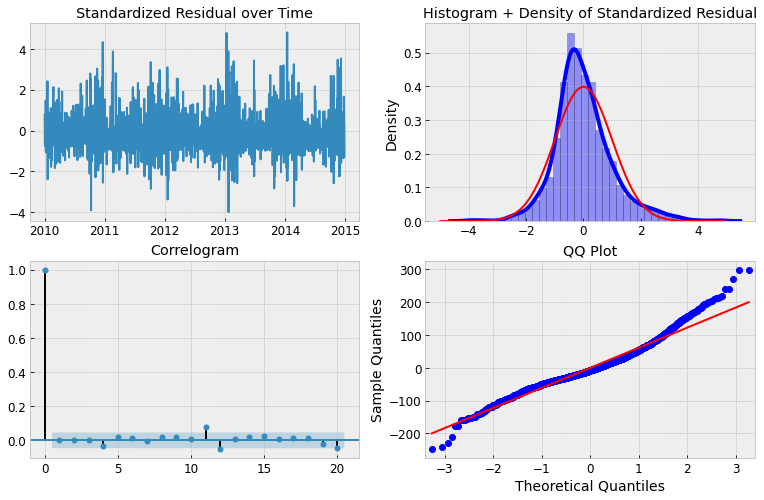

Ljung-Box Test (H0: the samples are uncorrelated)

Hypothesis H0 not rejected → the samples are uncorrelated



100%|██████████| 364/364 [02:42<00:00,  2.24it/s]


<Figure size 432x288 with 0 Axes>

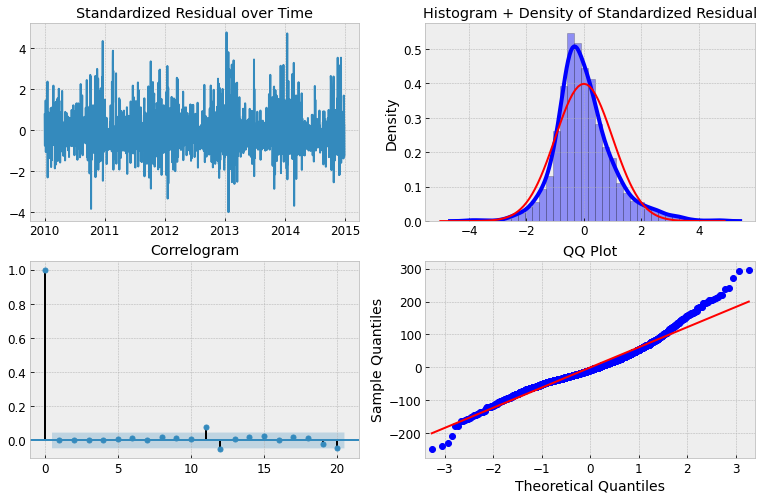

Ljung-Box Test (H0: the samples are uncorrelated)

Hypothesis H0 not rejected → the samples are uncorrelated



<Figure size 432x288 with 0 Axes>

In [9]:
# 2.2 Build Candidate Models and perform diagnostics
# ARMA(0,3) 
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.pollution_today, order=(0,0,3))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

e=model_fit.resid
yhat = pd.concat(yhat)
resultsDict['MA'] = evaluate(df_test.pollution_today, yhat.values)
FE=_error(df_test.pollution_today, yhat.values)
predictionsDict['MA'] = yhat.values
## 2.2.1 ~ 2.2.2
diag(e,'MA')
resultsDict['MA']['LBQ'] = lbq_test(e)
resultsDict['MA']['BIC'] = model_fit.bic
resultsDict['MA']['AIC'] = model_fit.aic
resultsDict['MA']['MPE'] = MPE(FE)
resultsDict['MA']['MZ'] = MZ(FE)


# ARMA(2,0)
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.pollution_today, order=(2,0,0))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

e=model_fit.resid
yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test.pollution_today, yhat.values)
FE=_error(df_test.pollution_today, yhat.values)
predictionsDict['AR'] = yhat.values
diag(e,'AR')
resultsDict['AR']['LBQ'] = lbq_test(e)
resultsDict['AR']['BIC'] = model_fit.bic
resultsDict['AR']['AIC'] = model_fit.aic
resultsDict['AR']['MPE'] = MPE(FE)
resultsDict['AR']['MZ'] = MZ(FE)

# ARMA(1,1)
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.pollution_today, order=(1,0,1))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

e=model_fit.resid
yhat = pd.concat(yhat)
resultsDict['ARMA11'] = evaluate(df_test.pollution_today, yhat.values)
FE=_error(df_test.pollution_today, yhat.values)
predictionsDict['ARMA11'] = yhat.values
diag(e,'ARMA11')
resultsDict['ARMA11']['LBQ'] = lbq_test(e)
resultsDict['ARMA11']['BIC'] = model_fit.bic
resultsDict['ARMA11']['AIC'] = model_fit.aic
resultsDict['ARMA11']['MPE'] = MPE(FE)
resultsDict['ARMA11']['MZ'] = MZ(FE)

# ARMA (2,2)
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.pollution_today))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.pollution_today, order=(1,0,3))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

e=model_fit.resid
yhat = pd.concat(yhat)
resultsDict['ARMA34'] = evaluate(df_test.pollution_today, yhat.values)
FE=_error(df_test.pollution_today, yhat.values)
predictionsDict['ARMA34'] = yhat.values
diag(e,'ARMA34')
resultsDict['ARMA34']['LBQ'] = lbq_test(e)
resultsDict['ARMA34']['BIC'] = model_fit.bic
resultsDict['ARMA34']['AIC'] = model_fit.aic
resultsDict['ARMA34']['MPE'] = MPE(FE)
resultsDict['ARMA34']['MZ'] = MZ(FE)

#### 2.3 Model Selection

In [10]:
# 2.3 Model Selection
evaluation =pd.DataFrame.from_dict(resultsDict)
evaluation

,MA,AR,ARMA11,ARMA34
mae,47.010560,47.148335,47.096852,47.030955
rmse,64.712263,64.959323,64.861691,64.777247
mape,1.002256,1.003716,1.005643,1.003066
r2,0.368678,0.363848,0.365759,0.367409
LBQ,1.000000,1.000000,1.000000,1.000000
BIC,20281.317200,20279.369333,20276.596726,20288.796886
AIC,20253.773264,20257.334185,20254.561577,20255.744163
MPE,1.000000,1.000000,1.000000,1.000000
MZ,1.000000,1.000000,1.000000,1.000000


In [11]:
evaluation.min(axis=1)

mae        47.010560
rmse       64.712263
mape        1.002256
r2          0.363848
LBQ         1.000000
BIC     20276.596726
AIC     20253.773264
MPE         1.000000
MZ          1.000000
dtype: float64